The notebook contains descriptive statistics and visualizations regarding rental prices, flow of publications and commissions charged by agents. Comments are always placed above the cells they relate to.

In [6]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import pathlib

%matplotlib inline

In [7]:
PROJECT_FOLDER_PATH = pathlib.Path().resolve().parent#'C:/Users/Arenter/Documents/Python Scripts/rent/Avito'
EDA_DF_PATH = PROJECT_FOLDER_PATH / 'data/interim/eda_df.csv'

In [8]:
df = pd.read_csv(EDA_DF_PATH, index_col=0, parse_dates=['parsing_date', 'pub_date', 'pub_time'])

To avoid the influence of seasonality effect I will restrict the observation period to 2 weeks and leave only the ads published after August 1. Besides, the data parsed on August 12 were corrupted and have to be deleted.

In [9]:
df = df[(df['pub_date'] >= pd.to_datetime('2020-08-01')) & (df['parsing_date'] != '2020-08-12')]

In [11]:
df.iloc[0]

commission_percent                           NaN
station_distance                               4
rent                                          65
pub_date                     2020-08-04 00:00:00
pub_time              2020-11-01 12:50:01.391968
studio                                         0
n_rooms                                        1
area                                          38
floor                                          7
n_floors                                      16
n_days                                         3
mcc                                            0
circle                                         0
center_distance                          2.06158
parsing_date                 2020-08-04 00:00:00
y                                        1.71053
Name: /moskva/kvartiry/1-k_kvartira_38.5_m_716_et._1980410476, dtype: object

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11778 entries, /moskva/kvartiry/1-k_kvartira_38.5_m_716_et._1980410476 to /moskva/kvartiry/studiya_31_m_1630_et._1971252114
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   commission_percent  6964 non-null   float64       
 1   station_distance    11778 non-null  int64         
 2   rent                11778 non-null  float64       
 3   pub_date            11778 non-null  datetime64[ns]
 4   pub_time            8121 non-null   datetime64[ns]
 5   studio              11778 non-null  int64         
 6   n_rooms             11778 non-null  int64         
 7   area                11778 non-null  int64         
 8   floor               11778 non-null  int64         
 9   n_floors            11778 non-null  int64         
 10  n_days              7259 non-null   float64       
 11  mcc                 11778 non-null  int64         
 12  circle   

In [14]:
#Number of missing values by column
df.isna().sum()

commission_percent    4814
station_distance         0
rent                     0
pub_date                 0
pub_time              3657
studio                   0
n_rooms                  0
area                     0
floor                    0
n_floors                 0
n_days                4519
mcc                      0
circle                   0
center_distance          0
parsing_date             0
y                        0
dtype: int64

## Prices

In [15]:
prices_by_rooms = (df[['pub_date', 'rent', 'y', 'n_rooms']]
                   .groupby(['pub_date', 'n_rooms'])
                   .median()
                   .unstack())

The supply of 4 and 5-room flats is so little that every new flat entering the market influences the median prices. The rental cost of 1 and 2-room flats is much more stable and is always between 0.8 and 1 thousand roubles per square meter.

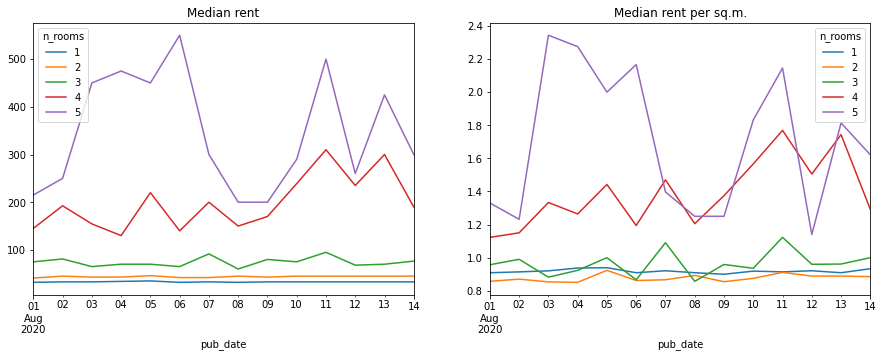

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
prices_by_rooms['rent'].plot(ax=axes[0], title='Median rent')
prices_by_rooms['y'].plot(ax=axes[1], title='Median rent per sq.m.')
plt.show()

Interestingly, rent per square meter does not decrease with number of rooms. Prices above 4 thousand per square meter are outliers for any number of rooms. 

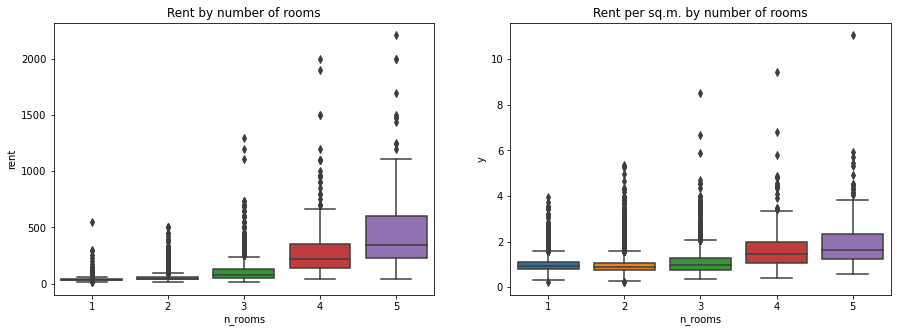

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sb.boxplot('n_rooms', 'rent', data=df)
plt.title('Rent by number of rooms')
plt.subplot(1, 2, 2)
sb.boxplot('n_rooms', 'y', data=df)
plt.title('Rent per sq.m. by number of rooms')
plt.show()

Without the outliers the box-plots are seen more clearly. Distributions of all prices tend to be right-skewed, the most notably for 5-bedroom apartments.  

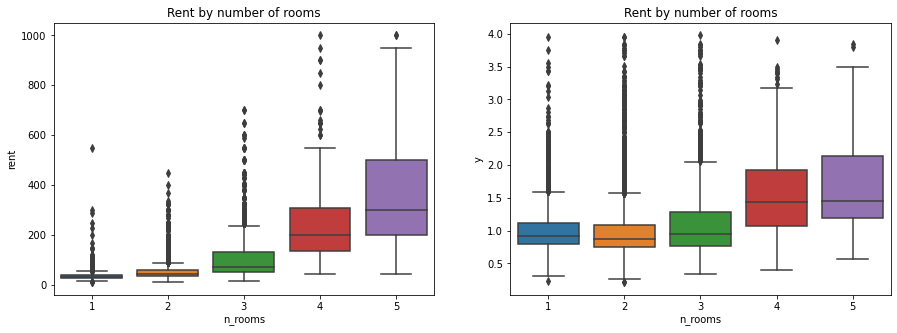

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sb.boxplot('n_rooms', 'rent', data=df[df['y']<4])
plt.title('Rent by number of rooms')
plt.subplot(1, 2, 2)
sb.boxplot('n_rooms', 'y', data=df[df['y']<4])
plt.title('Rent per square meter by number of rooms')
plt.show()

Rental prices have moderate negative correlation with distance to the closest station and remoteness to the city center.

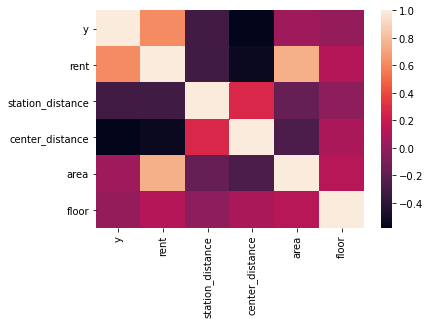

In [20]:
corr_cols = ['y', 'rent', 'station_distance', 'center_distance', 'area', 'floor']
sb.heatmap(df[corr_cols].corr('spearman'))
plt.show()

## Publication flow

In [21]:
count_by_rooms = df.groupby(['pub_date', 'n_rooms']).count().unstack()

On average, 800-900 flats enter the market daily. 35-45% of them are 1-room, 35-40% are 2-room. 4 and 5-room flats together never account for more than 10% of the market.

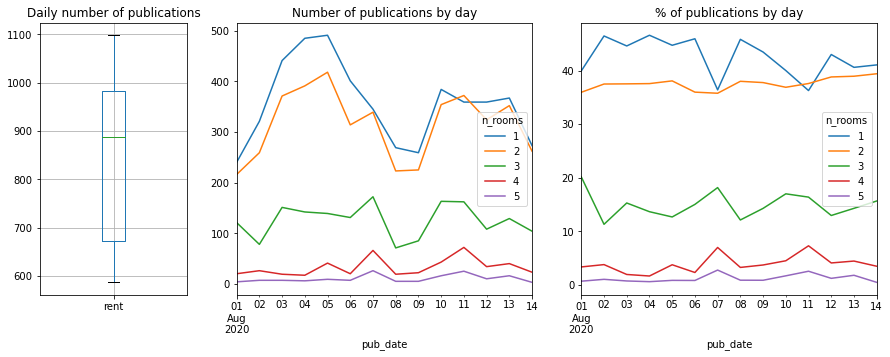

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 2, 2]})
df.groupby('pub_date').count().boxplot(column='rent', ax=axes[0])
axes[0].set_title('Daily number of publications')
count_by_rooms['rent'].plot(title='Number of publications by day', ax=axes[1])
((pd.crosstab(df['pub_date'], df['n_rooms'], normalize='index')*100)
 .plot(title='% of publications by day', ax=axes[2]))
plt.show()

In [23]:
df['pub_hour'] = df['pub_time'].dt.hour

About a half of ads is published between 10 a.m. and 18 p.m. The average rate of publications flow during that period is 50 to 70 ads per hour. Only 10% of ads is published in night hours. 

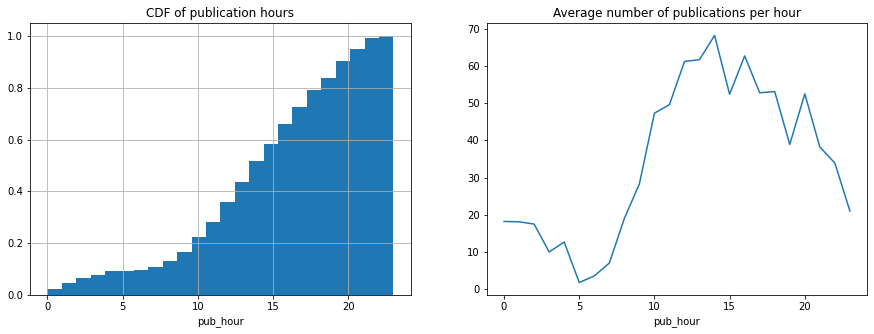

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df['pub_hour'].hist(bins=24, density=True, cumulative=True, ax=axes[0])
axes[0].set_title('CDF of publication hours')
axes[0].set_xlabel('pub_hour')
(df.groupby(['pub_hour', 'pub_date'])
 .count()
 .groupby('pub_hour')
 .mean()['rent']
 .plot(title='Average number of publications per hour', ax=axes[1]))
plt.show()

The flats near circle stations are rented faster. Proximity to Moscow Central Circle does not make a difference.

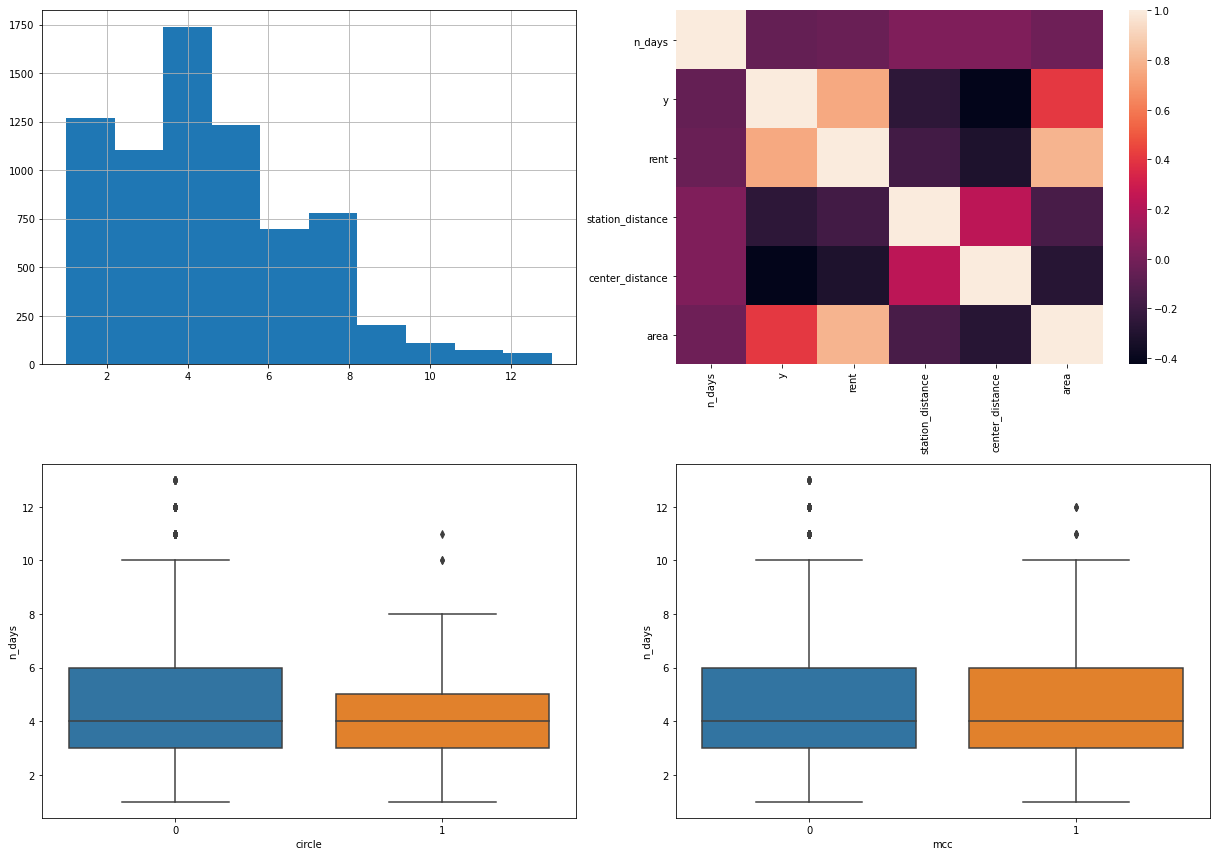

In [25]:
plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
df['n_days'].hist()
plt.subplot(2, 2, 2)
corr_cols = ['n_days', 'y', 'rent', 'station_distance', 'center_distance', 'area']
sb.heatmap(df[corr_cols].corr())
plt.subplot(2, 2, 3)
sb.boxplot('circle', 'n_days', data=df)
plt.subplot(2, 2, 4)
sb.boxplot('mcc', 'n_days', data=df)
plt.tight_layout()
plt.show()

## Commissions

The more rooms the flat has, the lower is the commission relative to its rental price. Almost a half of the flats are rented with 50% commission. A quarter of ads are commission-free (which can be considered to be an upper bound of the share of flats rented without agent intermediation). All other options account for less than 10% of flats each.

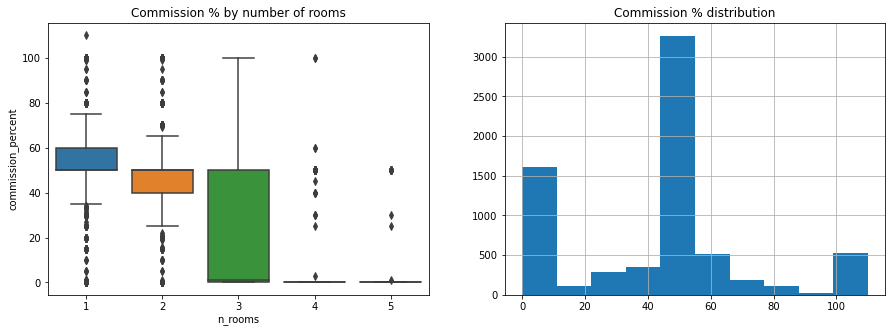

In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sb.boxplot('n_rooms', 'commission_percent', data=df); plt.title('Commission % by number of rooms')
plt.subplot(1, 2, 2)
df['commission_percent'].hist(); plt.title('Commission % distribution')
plt.show()

In [27]:
commission_freq = (df['commission_percent'].value_counts(normalize=True)
                                           .head().round(2)
                                           .to_frame('share of flats'))
commission_freq.index.name = 'Commission %'
commission_freq

,share of flats
Commission %,
50.0,0.46
0.0,0.23
100.0,0.07
60.0,0.06
40.0,0.04


More expensive flats tend to have lower commissions.

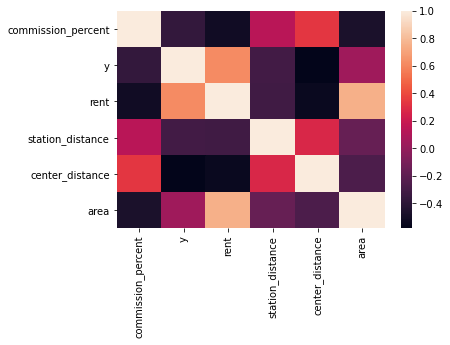

In [28]:
corr_cols = ['commission_percent', 'y', 'rent', 'station_distance', 'center_distance', 'area']
sb.heatmap(df[corr_cols].corr('spearman'))
plt.show()

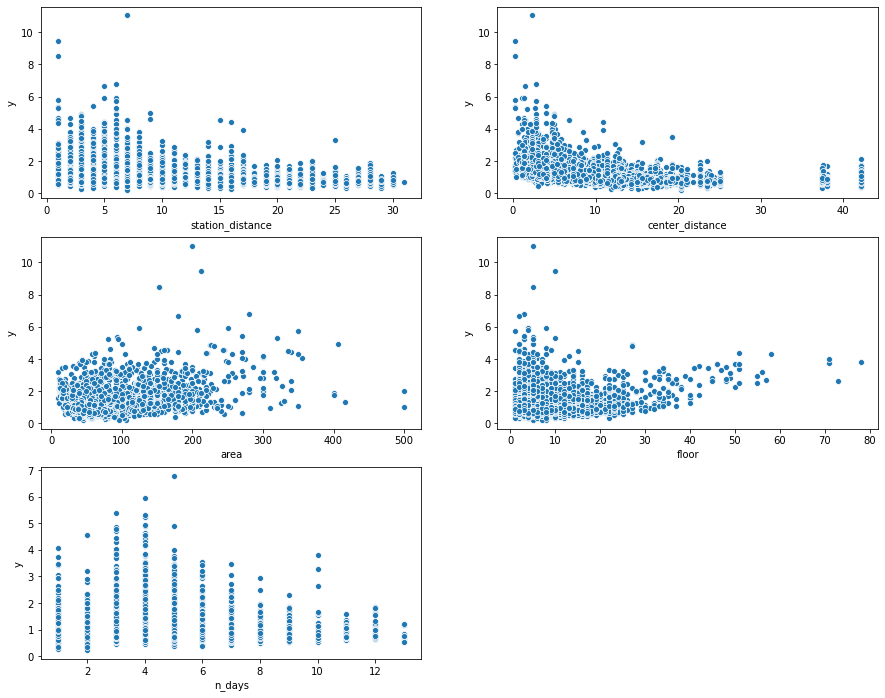

In [29]:
plt.figure(figsize=(15, 12))
plt.subplot(3, 2, 1)
sb.scatterplot('station_distance', 'y', data=df)
plt.subplot(3, 2, 2)
sb.scatterplot('center_distance', 'y', data=df)
plt.subplot(3, 2, 3)
sb.scatterplot('area', 'y', data=df)
plt.subplot(3, 2, 4)
sb.scatterplot('floor', 'y', data=df)
plt.subplot(3, 2, 5)
sb.scatterplot('n_days', 'y', data=df)
plt.show()

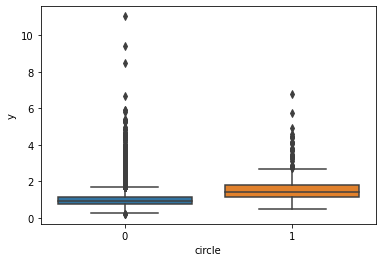

In [30]:
sb.boxplot('circle', 'y', data=df)

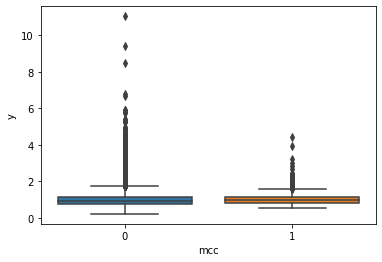

In [31]:
sb.boxplot('mcc', 'y', data=df)

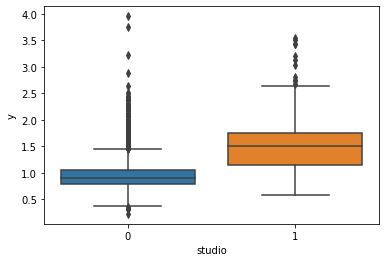

In [32]:
sb.boxplot('studio', 'y', data=df[df['n_rooms']==1])

In [33]:
one_room = df[df['n_rooms']==1]

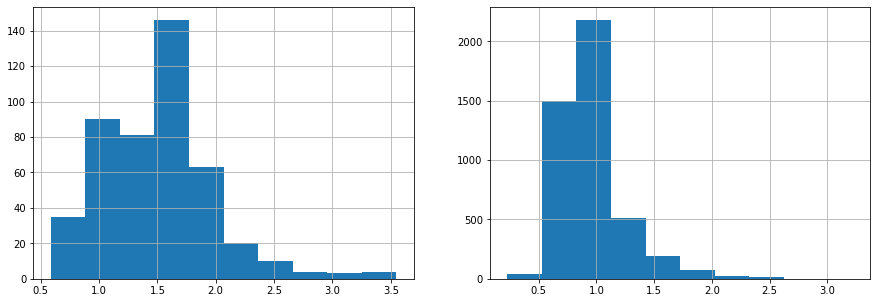

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
one_room.loc[one_room['studio'] == 1, 'y'].hist()
plt.subplot(1, 2, 2)
one_room.loc[(one_room['studio'] != 1) & (one_room['y'] < 3.5), 'y'].hist()
plt.show()

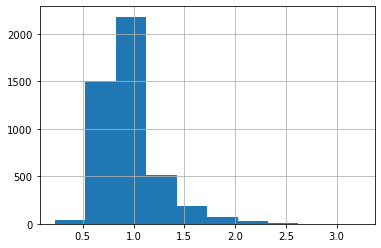

In [35]:
one_room.loc[(one_room['studio'] != 1) & (one_room['y'] < 3.5), 'y'].hist()

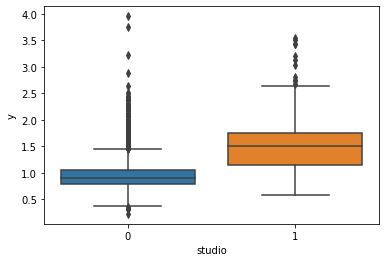

In [36]:
sb.boxplot('studio', 'y', data=df[df['n_rooms']==1])

In [37]:
df[df['n_rooms']==1]['studio'].value_counts()

0    4538
1     456
Name: studio, dtype: int64

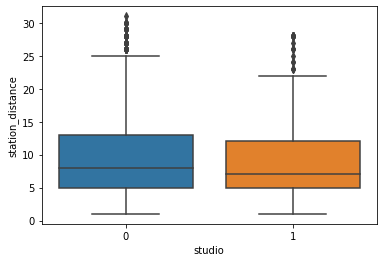

In [38]:
sb.boxplot('studio', 'station_distance', data=df[df['n_rooms']==1])

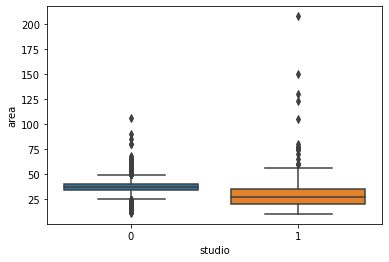

In [39]:
sb.boxplot('studio', 'area', data=df[df['n_rooms']==1])